<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

This notebook is run inside the iraf27 environment in linux but saved in Windows desktop.

In [1]:
from datetime import datetime as dt
print('Last accessed on: {}'.format(dt.now()))

Last accessed on: 2016-11-27 09:08:45.059866


# SU Aur data reduction
* K-band 
* qPDI 
* obsdate: 2014/10/09
* 582 - 638.fits
* without mask
* 10s exposure, 2 co-adds
* 599-638 science, 1% ND
* astroconda/iraf27 envi on Linux
* folderloc: ~/Downloads/research/SUAur/SUAur_data/K-band/science

In [1]:
#no need since astroconda env has been activated prior to launching ipynb
#!souce activate astroconda

After following installation procedure of astroconda and iraf27 environments in conda, I installed separately the X11 environment in order to run pyraf in ipython.

> sudo apt-get install libx11-dev

After that, I pip install pyraf and it downloaded and compiled without errors.

In [2]:
from pyraf import iraf
import pyfits

Created directory /home/dl/Downloads/research/SUAur/SUAur_data/K-band/notebook/pyraf for cache


In [3]:
!pwd

/home/dl/Downloads/research/SUAur/SUAur_data/K-band/notebook


I will first make a temporary variable using alias corresponding to the folder directory.

In [6]:
!alias folderloctest='home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/'
!cd $folderloctest
!pwd

/home/dl/Downloads/research/SUAur/SUAur_data/K-band/notebook


I can't seem to change the present working directory (pwd).

# Checking Images
* cross-check RXJ1633 reduction: ~/Downloads/research/rxj1633/1crop

In [153]:
from glob import glob
folderloctest='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/'
#file_list=glob(folderloc+'*.fits')
file_list=glob(folderloctest+'*.fits')
len(file_list)

4

In [158]:
file_list

['/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/HICA00152599.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/HICA00152600.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/HICA00152601.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/HICA00152602.fits']

There are 120 .fits file in the science image directory. Let's check some of them using ds9.

In [189]:
!alias folderloctest='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test'
!ds9 $folderloctest/*.fits

I could not make ds9 run in the background separately (using &):

!ds9 $folderloc/*599.fits &

So, make sure that ds9 is closed before proceeding below. 

Alternatively, let's show the image using pyfits as follows. First, let's determine the range of the pixel value.

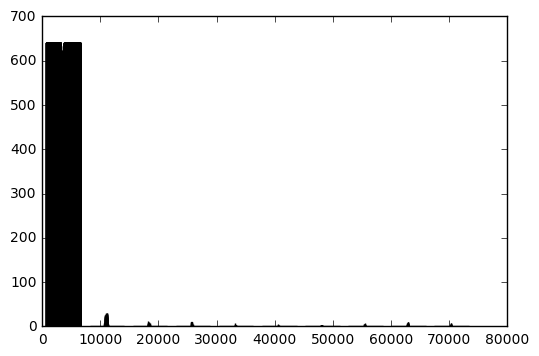

In [34]:
pl.hist(obj);

The range is [0, 70e3]. To increase contrast and see faint features in the image, let's set the image stretch for [0,10e3] only.

Populating the interactive namespace from numpy and matplotlib


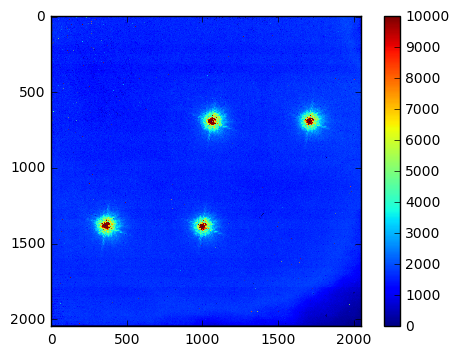

In [160]:
from matplotlib import pylab as pl
%pylab inline
import pyfits
import numpy as np

z=pyfits.open(file_list[0])
obj=z[0].data
#z[0].header
z.close()

cmap=[cm.gray, cm.jet]
#cmap.set_bad('black',1)
vmin, vmax = (0, 10e3)
pl.imshow(obj, cmap=cmap[1], vmin=vmin,vmax=vmax)
pl.colorbar()
print(file_list[0][-22:-5])
print(file_list[0][-17:-5])

Seen from above, the artifacts such as uneven illumination, horizontal stripes, bad (e.g. white) pixels are evident. We will try to remove them during the image processing as follows.

Next, we will crop 4 5"x5" channels from the raw image. The coordinates are defined in ch1,...,ch4. We will then save the cropped images as a separate .fits file using its original filename+ channel number (e.g. HICA 599 _ ch1.fits).  

In [166]:
print(file_list[0].translate(None, '*e /')[-17:])
print(file_list[0].translate(None, '*e /')[-17:].translate(None, '.fits'))

HICA00152599.fits
HICA00152599


By the way, do not forget to check the header for essential information.

In [41]:
z[0].header

SIMPLE  =                    T / Written by IDL:  Fri Oct 10 04:14:27 2014      
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                 2048 /                                                
NAXIS2  =                 2048 /                                                
EXTEND  =                    T / FITS data may contain extensions               
DATE    = '2014-10-10'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
P_HSTEND= '04:14:26.471'       /HST when exposure ends                          
P_HSTSTR= '04:13:56.596'       /HST when exposure starts                        
P_TFRAME=            1.4547900 /Frame time in sec                               
P_IREAD =                   

In [128]:
pyfits.open(file_list[0])[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                  640 / Axis length                                    
NAXIS2  =                  640 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '2016-11-25T11:18:57' / Time of last modification                     
OBJECT  = 'SUAUR   '           / Name of the object observed                    
DATE    = '2016-11-25T11:18:57' / Creation UTC (CCCC-MM-DD) date of FITS header 
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
P_HSTEND= '04:13:43.503'    

# 1. Cropping 

In [167]:
#!/home/dl/miniconda2/envs/iraf27
from pyraf import iraf
from glob import glob

ch1='[60:699,1100:1739]' 	#1.624 microns
ch2='[695:1334,1100:1739]' 	#1.600
ch3='[755:1394,415:1054]' 	#1.575
ch4='[1395:2034,410:1049]' 	#1.644

folderloctest='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/'
file_list=glob(folderloctest+'HICA*.fits')
file_list=list(file_list)
file_list.sort()

#n=len(file_list)
#loop over file_list[0-n]
for filename in file_list:
    filename_short=filename.translate(None, '*e /')[-18:].translate(None, '.fits')
    #filename=filename[-20:].translate(None, '.fits')
    a1=filename+ch1
    b1=filename_short+'_ch1'
    a2=filename+ch2
    b2=filename_short+'_ch2'
    a3=filename+ch3
    b3=filename_short+'_ch3'
    a4=filename+ch4
    b4=filename_short+'_ch4'
#   print filename, a1, b1, a2, b2, a3, b3, a4, b4

    iraf.imcopy(a1,b1); ##extract (crop) the 4 portions of the image file and 
    iraf.imcopy(a2,b2); ##save using the filename[i]
    iraf.imcopy(a3,b3);
    iraf.imcopy(a4,b4);

/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/HICA00152599.fits[60:699,1100:1739] -> HICA00152599_ch1
/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/HICA00152599.fits[695:1334,1100:1739] -> HICA00152599_ch2
/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/HICA00152599.fits[755:1394,415:1054] -> HICA00152599_ch3
/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/HICA00152599.fits[1395:2034,410:1049] -> HICA00152599_ch4
/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/HICA00152600.fits[60:699,1100:1739] -> HICA00152600_ch1
/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/HICA00152600.fits[695:1334,1100:1739] -> HICA00152600_ch2
/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/HICA00152600.fits[755:1394,415:1054] -> HICA00152600_ch3
/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/HICA00152600.fits[1395:2034,410:1049] -> HICA00152600_ch4
/home/dl/Downloads/res

After cropping and verifying from ds9, let's move the cropped files to a new folder. Note that we use the $ everytime the alias is used in the shell. 

Let's quickly check all the cropped images.

In [197]:
!alias filedir1='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop'
!ds9 $filedir1/*.fits

# 2. Destriping

We will subtract the background noise and stripe pattern to all the science images (ch1-ch4).

In [179]:
from datetime import datetime as dt
print('Last accessed on: {}'.format(dt.now()))

Last accessed on: 2016-11-27 13:38:06.308572


In [180]:
import glob
filedir1='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/'
file_list=glob.glob(filedir1+'HICA*')
file_list.sort()
file_list

['/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/HICA00152599_ch1.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/HICA00152599_ch2.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/HICA00152599_ch3.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/HICA00152599_ch4.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/HICA00152600_ch1.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/HICA00152600_ch2.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/HICA00152600_ch3.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/HICA00152600_ch4.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/HICA00152601_ch1.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/HICA00152601_ch2.fits',
 '/home/dl/Downloads/research/

In [181]:
#!/usr/bin/env python
from matplotlib import pylab as pl
%pylab inline
import pyfits
import glob

filedir1='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/'
file_list=glob.glob(filedir1+'HICA*')
file_list.sort()

for filename in file_list: #subtract the background to all the science images (ch1-ch4)
    #remove '.fits' from filename to be appended as 'b.fits'
    filename_short=filename.translate(None, '*e /')[-21:].translate(None, '.fits')
    a=pyfits.open(filename)
    image=copy(a[0].data)
    a.close()
    for y in range(image.shape[0]):
        med1=median(image[y,:100]) #take the median of y-values from 0:100 (101-499 is omitted because it contains bright star)
        med2=median(image[y,-100:])#take the median of y-values from 500:600
        image[y]-=(med1+med2)*0.5 #bg is subtracted by subtracting the average of the median of pixels along x-values considered above to y-values
    #figure(1)
    #clf()
    #imshow(image,vmin=-20,vmax=20)
    #show()
    hdu = pyfits.PrimaryHDU(image) #retain header file
    hdulist = pyfits.HDUList([hdu])
    hdulist.writeto(filename_short+'b.fits') #save as 'HICA*b.fits'
    hdulist.close()

#a[0].data=image
#a.writeto('HICA00137132b_ch1.fits')
#a.close()

Populating the interactive namespace from numpy and matplotlib


Let's check the results after moving the results from notebook directory to /2destripe.

In [196]:
!alias filedir2='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/2destripe'
!ds9 $filedir2/*b.fits

Or let's quickly compare the step 1 and step 2 output.

In [198]:
from glob import glob

fileloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/'
before=glob(fileloc+'1crop/'+'*.fits')
before.sort()
after =glob(fileloc+'2destripe/'+'*b.fits')
after.sort()
print(before[0])
print(after[0])
print(len(before)==len(after))

/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/HICA00152599_ch1.fits
/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/2destripe/HICA00152599_ch1b.fits
True


In [204]:
fileloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/'
before=glob(fileloc+'1crop/'+'*.fits')
before.sort()
after =glob(fileloc+'2destripe/'+'*b.fits')
after.sort()

pairs=1
infile1, infile2 = before[:pairs], after[:pairs]
print(infile1)
print(infile2)

['/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/1crop/HICA00152599_ch1.fits']
['/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/2destripe/HICA00152599_ch1b.fits']


Populating the interactive namespace from numpy and matplotlib


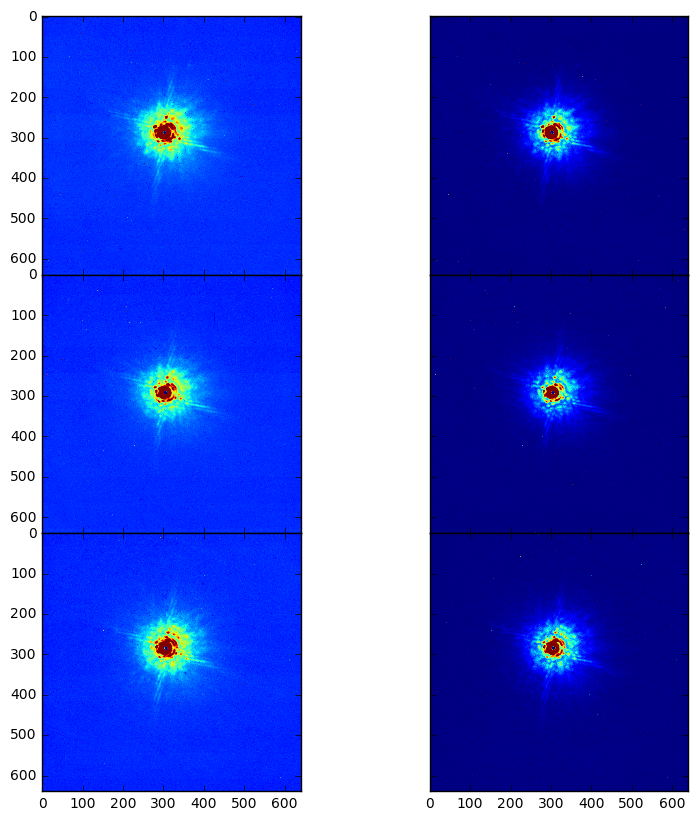

In [205]:
from matplotlib import pylab as pl
%pylab inline
import pyfits
import numpy as np
from glob import glob

fileloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/'
before=glob(fileloc+'1crop/'+'*.fits')
before.sort()
after =glob(fileloc+'2destripe/'+'*b.fits')
after.sort()

vmin, vmax = (0, 10e3)
cmap=[cm.gray, cm.jet]

pairs=3
infile1, infile2 = before[:pairs], after[:pairs]

fig, axes = pl.subplots(nrows=pairs, ncols=2, squeeze=False, sharex=True, sharey=True, figsize=(10,10))

def showfig(axrow, x, y):
    im = axrow[0].imshow(x, cmap=cmap[1], vmin=vmin,vmax=vmax, label='{}'.format(z1[0].header['FRAMEID']))
    axrow[0].set_adjustable('box-forced')
    #image extent=[0,obj1.shape[0],0,obj1.shape[1]]
    axrow[1].imshow(y, cmap=cmap[1], vmin=vmin,vmax=vmax)#, label='{}'.format(z2[0].header['FRAMEID']))
    axrow[1].set_adjustable('box-forced')
    
for i,j, counter, row in zip(infile1, infile2, range(pairs), axes):
    z1=pyfits.open(i)
    z2=pyfits.open(j)
    obj1=z1[0].data
    obj2=z2[0].data
    z1.close()
    z2.close()
    showfig(row, obj1, obj2) 
fig.subplots_adjust(wspace=0, hspace=0)
#pl.tight_layout()
#fig.colorbar(im,  ax=axes.ravel().tolist(), orientation='horizontal')
pl.legend()
pl.show()

Next task is to figure out how pyraf routines such as imcopy can include original header files.

## Master Flat

In [206]:
from datetime import datetime as dt
print('Last accessed on: {}'.format(dt.now()))

Last accessed on: 2016-11-27 13:53:35.996576


In [210]:
!alias flatloc='home/dl/Downloads/research/SUAur/SUAur_data/K-band/calib/QPDIflatK_Oct2014'

try:
    !ds9 $flatloc/HICA*.fits
except Exception as e:
    print('Error: {}'.format())

After checking the files, images 26 to 35 will be used to make master flat. 

(10, 2048, 2048)


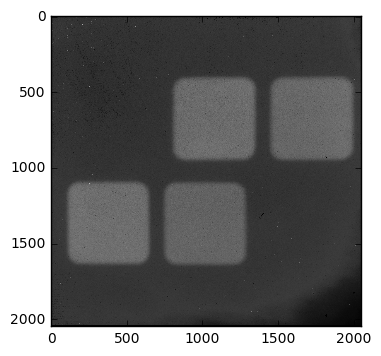

In [211]:
flatdirloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/calib/QPDIflatK_Oct2014/'

from pylab import *
from pyraf import iraf
import glob
import matplotlib.pyplot as pl
import pyfits

file_list=glob.glob(flatdirloc+'HICA*.fits')
file_list=list(file_list)
file_list.sort()

flats = array([pyfits.getdata("%s" % n) for n in file_list])
print(shape(flats))
master_flat = median(flats,axis=0)
#print shape(dark)
pl.imshow(master_flat,cmap=cm.gray)
#imshow(log(flat),cmap=cm.gray)

## Saving master flat image

In [214]:
hdu = pyfits.PrimaryHDU(master_flat) #retain header file
hdulist = pyfits.HDUList([hdu])
hdulist.writeto('master_flat.fits')
hdulist.close()

In [215]:
!ds9 master_flat.fits

In [216]:
from pylab import *
from pyraf import iraf

ch1='[60:699,1100:1739]' 	#1.624 microns
ch2='[695:1334,1100:1739]' 	#1.600
ch3='[755:1394,415:1054]' 	#1.575
ch4='[1395:2034,410:1049]' 	#1.644

filename='master_flat'

a1=filename+ch1
b1=filename+'_ch1'
a2=filename+ch2
b2=filename+'_ch2'
a3=filename+ch3
b3=filename+'_ch3'
a4=filename+ch4
b4=filename+'_ch4'

iraf.imcopy(a1,b1)
iraf.imcopy(a2,b2)
iraf.imcopy(a3,b3)
iraf.imcopy(a4,b4)

master_flat[60:699,1100:1739] -> master_flat_ch1
master_flat[695:1334,1100:1739] -> master_flat_ch2
master_flat[755:1394,415:1054] -> master_flat_ch3
master_flat[1395:2034,410:1049] -> master_flat_ch4


In [217]:
!ds9 *.fits

Channel 1 is dimmer than all the other channels.

# 3. Flat fielding (flat division)

In [211]:
'''
When I used imarith division, the error says
that the input image is not an image nor a number.
So I opted to do my own matrix division.
Be careful because error caused by div by 0 showed up.
'''
#!/usr/bin/env python
#!/usr/bin/env python
from pylab import *
from pyraf import iraf
import pyfits
import glob

folderloc2='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/2destripe/'
file_list1=glob.glob(folderloc2+'HICA*ch1b.fits')
file_list2=glob.glob(folderloc2+'HICA*ch2b.fits')
file_list3=glob.glob(folderloc2+'HICA*ch3b.fits')
file_list4=glob.glob(folderloc2+'HICA*ch4b.fits')

file_list1.sort()
file_list2.sort()
file_list3.sort()
file_list4.sort()

'''
flat_list=glob.glob('master*.fits')
flat_list=list(flat_list)
flat_list.sort()
'''
folderloc3='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/3flat/'
a=pyfits.open(folderloc3+'master_flat_ch1.fits')
flat_ch1=copy(a[0].data)
a.close()

b=pyfits.open(folderloc3+'master_flat_ch2.fits')
flat_ch2=copy(b[0].data)
b.close()

c=pyfits.open(folderloc3+'master_flat_ch3.fits')
flat_ch3=copy(c[0].data)
c.close()

d=pyfits.open(folderloc3+'master_flat_ch4.fits')
flat_ch4=copy(d[0].data)
d.close()

#master_flat_ch1 = array([pyfits.getdata('master_flat_ch1.fits')])

for filename1 in file_list1: #loop to all the science images (ch1b)
    filename1_short=filename1[-22:]
    fname1=filename1_short[:-5]+'f.fits'
    print(filename1_short,fname1)
    #iraf.imarith(filename1,'/','master_flat_ch1',fname1)#make flat field by dividing flat
    z=pyfits.open(filename1)
    z_image=copy(z[0].data)
    if z_image.shape == flat_ch1.shape:
        fname1_image = z_image / flat_ch1
    else:
        print('inputs not same shape')
    z.close()
    hdu = pyfits.PrimaryHDU(fname1_image) #retain header file
    #hdulist = pyfits.HDUList([hdu])
    #hdulist.writeto(fname1+'f.fits') #save as 'HICA*bf.fits'
    #hdulist.close()
    hdu.writeto(fname1)

for filename2 in file_list2: #loop to all the science images (ch1b)
    filename2_short=filename2[-22:]
    fname2=filename2_short[:-5]+'f.fits'
    print(filename2_short,fname2)
    z=pyfits.open(filename2)
    z_image=copy(z[0].data)
    if z_image.shape == flat_ch2.shape:
        fname2_image = z_image / flat_ch2
    else:
        print('inputs not same shape')
    z.close()
    hdu = pyfits.PrimaryHDU(fname2_image)
    hdu.writeto(fname2)

for filename3 in file_list3: #loop to all the science images (ch1b)
    filename3_short=filename3[-22:]
    fname3=filename3_short[:-5]+'f.fits'
    print(filename3_short,fname3)
    z=pyfits.open(filename3)
    z_image=copy(z[0].data)
    if z_image.shape == flat_ch3.shape:
        fname3_image = z_image / flat_ch3
    else:
        print('inputs not same shape')
    z.close()
    hdu = pyfits.PrimaryHDU(fname3_image)
    hdu.writeto(fname3)

for filename4 in file_list4: #loop to all the science images (ch1b)
    filename4_short=filename4[-22:]
    fname4=filename4_short[:-5]+'f.fits'
    print(filename4_short,fname4)
    z=pyfits.open(filename4)
    z_image=copy(z[0].data)
    if z_image.shape == flat_ch4.shape:
        fname4_image = z_image / flat_ch4
    else:
        print('inputs not same shape')
    z.close()
    hdu = pyfits.PrimaryHDU(fname4_image)
    hdu.writeto(fname4)

('HICA00152599_ch1b.fits', 'HICA00152599_ch1bf.fits')
('HICA00152600_ch1b.fits', 'HICA00152600_ch1bf.fits')
('HICA00152601_ch1b.fits', 'HICA00152601_ch1bf.fits')
('HICA00152602_ch1b.fits', 'HICA00152602_ch1bf.fits')
('HICA00152599_ch2b.fits', 'HICA00152599_ch2bf.fits')
('HICA00152600_ch2b.fits', 'HICA00152600_ch2bf.fits')
('HICA00152601_ch2b.fits', 'HICA00152601_ch2bf.fits')
('HICA00152602_ch2b.fits', 'HICA00152602_ch2bf.fits')
('HICA00152599_ch3b.fits', 'HICA00152599_ch3bf.fits')
('HICA00152600_ch3b.fits', 'HICA00152600_ch3bf.fits')
('HICA00152601_ch3b.fits', 'HICA00152601_ch3bf.fits')
('HICA00152602_ch3b.fits', 'HICA00152602_ch3bf.fits')
('HICA00152599_ch4b.fits', 'HICA00152599_ch4bf.fits')
('HICA00152600_ch4b.fits', 'HICA00152600_ch4bf.fits')
('HICA00152601_ch4b.fits', 'HICA00152601_ch4bf.fits')
('HICA00152602_ch4b.fits', 'HICA00152602_ch4bf.fits')


In [212]:
!ds9 *bf.fits

After moving the files from notebook folder to /3flat,

In [213]:
!alias folderloc3='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/3flat' 
!ds9 $folderloc3/*bf.fits

The images look a little off in the edges. I should check that.

Populating the interactive namespace from numpy and matplotlib


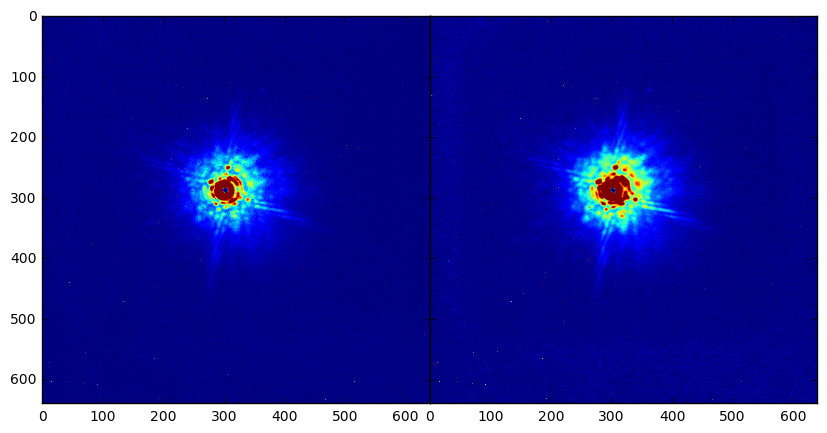

In [217]:
from matplotlib import pylab as pl
%pylab inline
import pyfits
import numpy as np
from glob import glob

fileloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/'
before=glob(fileloc+'2destripe/'+'*b.fits')
before.sort()
after =glob(fileloc+'3flat/'+'HICA*bf.fits')
after.sort()

vmin, vmax = (0, 10e3)
cmap=[cm.gray, cm.jet]

pairs=1
infile1, infile2 = before[:pairs], after[:pairs]

fig, axes = pl.subplots(nrows=pairs, ncols=2, squeeze=False, sharex=True, sharey=True, figsize=(10,10))

def showfig(axrow, x, y):
    im = axrow[0].imshow(x, cmap=cmap[1], vmin=vmin,vmax=vmax)#, label='{}'.format(z1[0].header['FRAMEID']))
    axrow[0].set_adjustable('box-forced')
    #image extent=[0,obj1.shape[0],0,obj1.shape[1]]
    axrow[1].imshow(y, cmap=cmap[1], vmin=0,vmax=0.4)#, label='{}'.format(z2[0].header['FRAMEID']))
    axrow[1].set_adjustable('box-forced')
    
for i,j, counter, row in zip(infile1, infile2, range(pairs), axes):
    z1=pyfits.open(i)
    z2=pyfits.open(j)
    obj1=z1[0].data
    obj2=z2[0].data
    z1.close()
    z2.close()
    showfig(row, obj1, obj2) 
fig.subplots_adjust(wspace=0, hspace=0)
#pl.tight_layout()
#fig.colorbar(im,  ax=axes.ravel().tolist(), orientation='horizontal')
pl.legend()
pl.show()

Note the extents (pixel values) of the two images above are different; the extent of the flat fielded images is between [0,1].

# 4. Geometric distortion correction

In [218]:
from datetime import datetime as dt
print('Last accessed on: {}'.format(dt.now()))

Last accessed on: 2016-11-27 14:10:16.501516


4 .db and 4 .dat files were downloaded from
http://ird.mtk.nao.ac.jp/SEEDS/calib/distortion/
and saved at /home/dl/Downloads/research/SUAur/SUAur_data/K-band

In [219]:
import glob
#db_dat_fileloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/calib/HiCIAO_to_HST_qPDI_2014Oct/'
db_dat_fileloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/notebook/'
db=glob.glob(db_dat_fileloc+'*.db')
db.sort()
dat=glob.glob(db_dat_fileloc+'*.dat')
dat.sort()
for i, j in zip(dat, db): 
    print(i[-15:], j[-14:])

('ch1_2014Oct.dat', 'ch1_2014Oct.db')
('ch2_2014Oct.dat', 'ch2_2014Oct.db')
('ch3_2014Oct.dat', 'ch3_2014Oct.db')
('ch4_2014Oct.dat', 'ch4_2014Oct.db')


Test if geotrans will work on a single set (ch4).

In [ ]:
for filename4 in file_list4:
    filename4_short=filename4[-23:]
    fname4=filename4_short[:-5]+'g.fits'
    iraf.geotran(filename4,fname4,database='HiCIAO_to_HST_ch4_2014Oct.db',transfor='HiCIAO_to_HST_ch4_2014Oct.db')

In [220]:
#!/usr/bin/env python
from pyraf import iraf
import pyfits
import glob

fileloc4='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/3flat/'
file_list1=glob.glob(fileloc4+'HICA*ch1bf.fits')
file_list2=glob.glob(fileloc4+'HICA*ch2bf.fits')
file_list3=glob.glob(fileloc4+'HICA*ch3bf.fits')
file_list4=glob.glob(fileloc4+'HICA*ch4bf.fits')

# file_list1=list(file_list1)
# file_list2=list(file_list2)
# file_list3=list(file_list3)
# file_list4=list(file_list4)
file_list1.sort()
file_list2.sort()
file_list3.sort()
file_list4.sort()


#db_dat_fileloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/calib/HiCIAO_to_HST_qPDI_2014Oct/'
db_dat_fileloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/notebook/'
db=glob.glob(db_dat_fileloc+'*.db')
db.sort()

dat=glob.glob(db_dat_fileloc+'*.dat')
dat.sort()

if len(db)==len(dat):
    for filename1 in file_list1:
        filename1_short=filename1[-23:]
        fname1=filename1_short[:-5]+'g.fits'
        iraf.geotran(filename1,fname1,database=db[0][-28:],transfor=dat[0][-29:])

    for filename2 in file_list2:
        filename2_short=filename2[-23:]
        fname2=filename2_short[:-5]+'g.fits'
        iraf.geotran(filename2,fname2,database=db[1][-28:],transfor=dat[1][-29:])

    for filename3 in file_list3:
        filename3_short=filename3[-23:]
        fname3=filename3_short[:-5]+'g.fits'
        iraf.geotran(filename3,fname3,database=db[2][-28:],transfor=dat[2][-29:])

    for filename4 in file_list4:
        filename4_short=filename4[-23:]
        fname4=filename4_short[:-5]+'g.fits'
        iraf.geotran(filename4,fname4,database=db[3][-28:],transfor=dat[3][-29:])


Transforming image /home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/3flat/HICA00152599_ch1bf.fits to image HICA00152599_ch1bfg.fits
    Using transform HiCIAO_to_HST_ch1_2014Oct.dat in database HiCIAO_to_HST_ch1_2014Oct.db

Transforming image /home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/3flat/HICA00152600_ch1bf.fits to image HICA00152600_ch1bfg.fits
    Using transform HiCIAO_to_HST_ch1_2014Oct.dat in database HiCIAO_to_HST_ch1_2014Oct.db

Transforming image /home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/3flat/HICA00152601_ch1bf.fits to image HICA00152601_ch1bfg.fits
    Using transform HiCIAO_to_HST_ch1_2014Oct.dat in database HiCIAO_to_HST_ch1_2014Oct.db

Transforming image /home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/3flat/HICA00152602_ch1bf.fits to image HICA00152602_ch1bfg.fits
    Using transform HiCIAO_to_HST_ch1_2014Oct.dat in database HiCIAO_to_HST_ch1_2014Oct.db

Transforming image /home/dl/Downloads/r

In [221]:
!ds9 *bfg.fits

After moving the files from notebook folder to /4geotrans,

Populating the interactive namespace from numpy and matplotlib


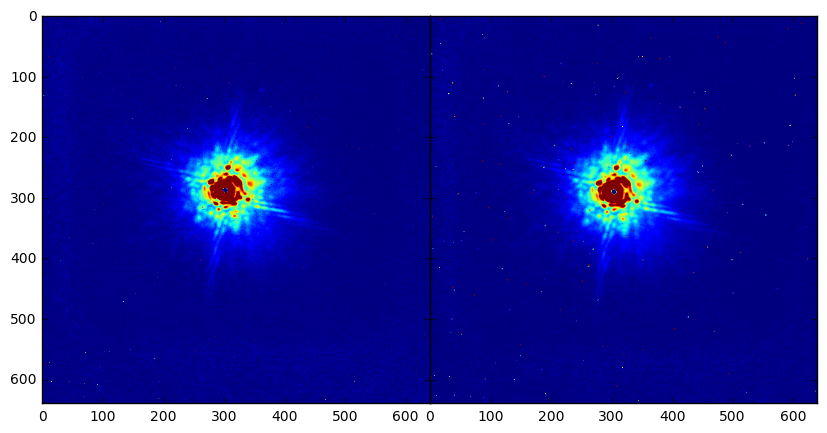

In [222]:
from matplotlib import pylab as pl
%pylab inline
import pyfits
import numpy as np
from glob import glob

fileloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/'
before=glob(fileloc+'3flat/'+'*bf.fits')
before.sort()
after =glob(fileloc+'4geotrans/'+'HICA*bfg.fits')
after.sort()

vmin, vmax = (0, 0.4)
cmap=[cm.gray, cm.jet]
#cmap.set_bad('black',1)

pairs=1
infile1, infile2 = before[:pairs], after[:pairs]

fig, axes = pl.subplots(nrows=pairs, ncols=2, squeeze=False, sharex=True, sharey=True, figsize=(10,5))

def showfig(axrow, x, y):
    im = axrow[0].imshow(x, cmap=cmap[1], vmin=vmin,vmax=vmax)#, label='{}'.format(z1[0].header['FRAMEID']))
    axrow[0].set_adjustable('box-forced')
    #image extent=[0,obj1.shape[0],0,obj1.shape[1]]
    axrow[1].imshow(y, cmap=cmap[1], vmin=vmin,vmax=vmax)#, label='{}'.format(z2[0].header['FRAMEID']))
    axrow[1].set_adjustable('box-forced')
    
for i,j, counter, row in zip(infile1, infile2, range(pairs), axes):
    z1=pyfits.open(i)
    z2=pyfits.open(j)
    obj1=z1[0].data
    obj2=z2[0].data
    z1.close()
    z2.close()
    showfig(row, obj1, obj2) 
fig.subplots_adjust(wspace=0, hspace=0)
#pl.tight_layout()
#fig.colorbar(im,  ax=axes.ravel().tolist(), orientation='horizontal')
pl.legend()
pl.show()

# 5. Bulk alignment

I will temporarily skip this and see the results first of o- and e-rays if they will subtract perfectly.

In [223]:
from datetime import datetime as dt
print('Last accessed on: {}'.format(dt.now()))

Last accessed on: 2016-11-27 14:13:09.886916


# 6. OE computation (not shifted)

In [224]:
import glob
folderloc5='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/4geotrans/'
file_list1=glob.glob(folderloc5+'HICA*ch1bfg.fits')
file_list2=glob.glob(folderloc5+'HICA*ch2bfg.fits')
file_list3=glob.glob(folderloc5+'HICA*ch3bfg.fits')
file_list4=glob.glob(folderloc5+'HICA*ch4bfg.fits')
file_list1.sort()
file_list2.sort()
file_list3.sort()
file_list4.sort()
[i for i in file_list1] #channel 1

['/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/4geotrans/HICA00152599_ch1bfg.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/4geotrans/HICA00152600_ch1bfg.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/4geotrans/HICA00152601_ch1bfg.fits',
 '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/4geotrans/HICA00152602_ch1bfg.fits']

In [225]:
image_list_ch1 = array([pyfits.getdata("%s" % n) for n in file_list1])
print(shape(image_list_ch1))
image_list_ch2 = array([pyfits.getdata("%s" % n) for n in file_list2])
print(shape(image_list_ch2))
image_list_ch3 = array([pyfits.getdata("%s" % n) for n in file_list3])
print(shape(image_list_ch3))
image_list_ch4 = array([pyfits.getdata("%s" % n) for n in file_list4])
print(shape(image_list_ch4))

(4, 640, 640)
(4, 640, 640)
(4, 640, 640)
(4, 640, 640)


In [226]:
image_list_ch1[1]

array([[-0.00079502,  0.00324424, -0.00058018, ..., -0.00893533,
        -0.00988341, -0.00672064],
       [-0.03110094, -0.00669813, -0.00136029, ..., -0.00778451,
         0.00216723,  0.00176955],
       [-0.01583517, -0.00640568,  0.00511513, ..., -0.01156321,
        -0.01295818, -0.0085954 ],
       ..., 
       [ 0.00691194, -0.00680514, -0.0138149 , ...,  0.00406805,
         0.00086722, -0.00428538],
       [ 0.00070731, -0.00293604,  0.01077559, ..., -0.00826155,
         0.00237715,  0.0077284 ],
       [-0.0161747 ,  0.00839046,  0.00589963, ..., -0.0076979 ,
         0.00368233,  0.00944373]], dtype=float32)

In [227]:
#!/home/dl/miniconda2/envs/iraf27
'''
FILENAME: 6oe_I_noshift.py
FOLDER LOCATION: 6oe_I
This file computes for OE rays and intensity of unaligned science images
to check whether it will yield reasonable Q and U images.
'''
#from pyraf import iraf
import glob
import pyfits
import numpy as np

folderloc5='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/4geotrans/'
file_list1=glob.glob(folderloc5+'HICA*ch1bfg.fits')
file_list2=glob.glob(folderloc5+'HICA*ch2bfg.fits')
file_list3=glob.glob(folderloc5+'HICA*ch3bfg.fits')
file_list4=glob.glob(folderloc5+'HICA*ch4bfg.fits')
file_list1.sort()
file_list2.sort()
file_list3.sort()
file_list4.sort()

image_list_ch1 = array([pyfits.getdata("%s" % n) for n in file_list1])
#print(shape(image_list_ch1))
image_list_ch2 = array([pyfits.getdata("%s" % n) for n in file_list2])
#print(shape(image_list_ch2))
image_list_ch3 = array([pyfits.getdata("%s" % n) for n in file_list3])
#print(shape(image_list_ch3))
image_list_ch4 = array([pyfits.getdata("%s" % n) for n in file_list4])
#print(shape(image_list_ch4))

##filenames
save_oe=range(len(file_list4))
save_I=range(len(file_list4))
out_ch2ch4=range(len(file_list4))
out_ch1ch3=range(len(file_list4))
oe=range(len(file_list4))
I=range(len(file_list4))
filename_org=range(len(file_list4))

'''
hdu = pyfits.PrimaryHDU(master_flat) #retain header file
hdulist = pyfits.HDUList([hdu])
hdulist.writeto('master_flat.fits')
hdulist.close()
'''

for j in range(len(file_list4)):			###get the number
    out_ch2ch4[j]=zeros((640,640))
    out_ch1ch3[j]=zeros((640,640))
    oe[j]=zeros((640,640))
    I[j]=zeros((640,640))
    ##o and e rays
    out_ch1ch3[j]=image_list_ch1[j]+image_list_ch3[j]
    out_ch2ch4[j]=image_list_ch2[j]+image_list_ch4[j]
    ###OE rays: (ch1+ch3) - (ch2+ch4)
    oe[j]=out_ch1ch3[j] - out_ch2ch4[j]		#may be needed to shift o&e first
    ###I rays: (ch1+ch3) + (ch2+ch4)
    I[j]=out_ch1ch3[j] + out_ch2ch4[j]
    save_oe[j]=file_list1[j][-24:-12]+'_oe.fits'
    save_I[j]=file_list1[j][-24:-12]+'_I.fits'
    pyfits.writeto(save_oe[j],oe[j])
    pyfits.writeto(save_I[j],I[j])
    print('Saved: {},{}'.format(save_oe[j],save_I[j]))

Saved: HICA00152599_oe.fits,HICA00152599_I.fits
Saved: HICA00152600_oe.fits,HICA00152600_I.fits
Saved: HICA00152601_oe.fits,HICA00152601_I.fits
Saved: HICA00152602_oe.fits,HICA00152602_I.fits


In [ ]:
!ds9 *oe.fits *I.fits

The oe images look aligned at first glance.

Now, after moving the files from notebook folder to /6oe,

Populating the interactive namespace from numpy and matplotlib


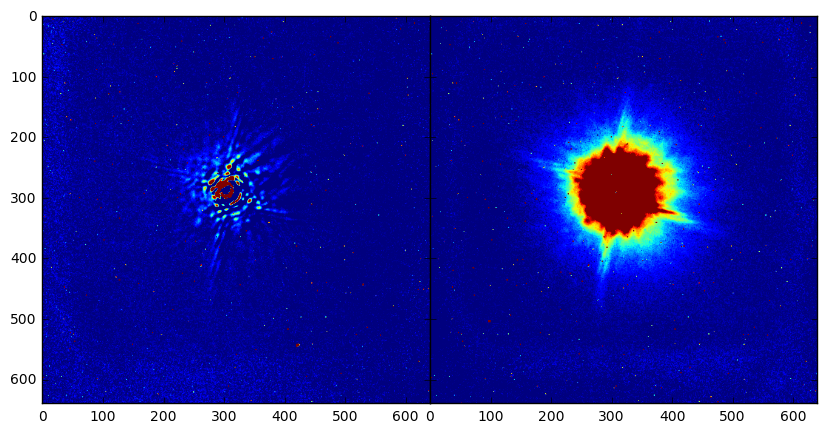

In [230]:
from matplotlib import pylab as pl
%pylab inline
import pyfits
import numpy as np
from glob import glob

fileloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/'
before=glob(fileloc+'6oe/'+'*oe.fits')
before.sort()
after =glob(fileloc+'6oe/'+'HICA*I.fits')
after.sort()

vmin, vmax = (0, 0.4)
cmap=[cm.gray, cm.jet]
#cmap.set_bad('black',1)

pairs=1
infile1, infile2 = before[:pairs], after[:pairs]

fig, axes = pl.subplots(nrows=pairs, ncols=2, squeeze=False, sharex=True, sharey=True, figsize=(10,5))

def showfig(axrow, x, y):
    im = axrow[0].imshow(x, cmap=cmap[1], vmin=vmin,vmax=vmax)#, label='{}'.format(z1[0].header['FRAMEID']))
    axrow[0].set_adjustable('box-forced')
    #image extent=[0,obj1.shape[0],0,obj1.shape[1]]
    axrow[1].imshow(y, cmap=cmap[1], vmin=vmin,vmax=vmax)#, label='{}'.format(z2[0].header['FRAMEID']))
    axrow[1].set_adjustable('box-forced')
    
for i,j, counter, row in zip(infile1, infile2, range(pairs), axes):
    z1=pyfits.open(i)
    z2=pyfits.open(j)
    obj1=z1[0].data
    obj2=z2[0].data
    z1.close()
    z2.close()
    showfig(row, obj1, obj2) 
fig.subplots_adjust(wspace=0, hspace=0)
#pl.tight_layout()
#fig.colorbar(im,  ax=axes.ravel().tolist(), orientation='horizontal')
pl.legend()
pl.show()

Look below how the code was reduced, bypassing all the unneccessary dummy variables such as hdu_list and indexing troubles.

# 7. Q and U images

In [234]:
import glob
fileloc7='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/7QU/'
loadfile=loadtxt(fileloc7+'IP_SUAur_20141009.txt',dtype=str) #convert all values to string
loadfile=array(loadfile)
#print(loadfile)

fileloc6='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/6oe/'
file_list_I=glob.glob(fileloc6+'*_I.fits')
file_list_I.sort()
#print(file_list_I)

file_list_oe=glob.glob(fileloc6+'*_oe.fits')
file_list_oe.sort()
#print(file_list_oe)

numofimage_I=len(file_list_I)

x11_all=loadfile[:,1]	#x11 parameter corresponds to 2nd column in txt file [:,1]
x11=range(len(x11_all))	#define the length of x11 array

x11={}
x21={}
x22={}
x23={}
x24={}

for line in loadfile:				#x11['382']
    file_no=line[0][-8:-5]
    x11[file_no]=float(line[1])
    x21[file_no]=float(line[5])
    x22[file_no]=float(line[6])
    x23[file_no]=float(line[7])
    x24[file_no]=float(line[8])
    #print(x11[file_no])

In [235]:
for num in file_list_I:
    num=num[-10:-7:]
    print(num)

599
600
601
602


This will be used to make PI image for a given set of waveplate rotation angle (4 files per PI). Let's see how many science images we have. There are -C1 and -C2 images but I don't know their difference from normal images. For example, -C1.fits have:

In [236]:
!alias scienceloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/C1/HICA*.fits'
!ls $scienceloc

HiCIAO_to_HST_ch1_2014Oct.dat  HiCIAO_to_HST_ch3_2014Oct.dat  pyraf
HiCIAO_to_HST_ch1_2014Oct.db   HiCIAO_to_HST_ch3_2014Oct.db   SUAur_Kband.ipynb
HiCIAO_to_HST_ch2_2014Oct.dat  HiCIAO_to_HST_ch4_2014Oct.dat
HiCIAO_to_HST_ch2_2014Oct.db   HiCIAO_to_HST_ch4_2014Oct.db


In [237]:
!alias scienceloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/C2/*C2.fits'
!ls $scienceloc -l | wc -l

11


I can't still cd inside jupyter so the ls result above is wrong. I checked the scienceloc (by using terminal) and it showed 40 each for -C1, -C2, and normal .fits files. Thus, the groups should have the following ids: 

In [238]:
first=int(file_list_I[0][-10:-7])
print(first)
example=range(first,first+40,4)
print(example)

599
[599, 603, 607, 611, 615, 619, 623, 627, 631, 635]


In [250]:
sciencedir='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/'
sci_list=glob.glob(sciencedir+'*.fits')
sci_list.sort()

print([i[-8:-5] for i in sci_list])

['599', '600', '601', '602', '603', '604', '605', '606', '607', '608', '609', '610', '611', '612', '613', '614', '615', '616', '617', '618', '619', '620', '621', '622', '623', '624', '625', '626', '627', '628', '629', '630', '631', '632', '633', '634', '635', '636', '637', '638']


Thus, the two cells above show that the naming convention is consistent with the ids of the science images (40 images in total).

In [251]:
fileloc6='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/6oe/'
file_list_I=glob.glob(fileloc6+'*_I.fits')
file_list_I.sort()
#print(file_list_I)

file_list_oe=glob.glob(fileloc6+'*_oe.fits')
file_list_oe.sort()
#print(file_list_oe)

['/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/6oe/HICA00152599_oe.fits', '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/6oe/HICA00152600_oe.fits', '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/6oe/HICA00152601_oe.fits', '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/6oe/HICA00152602_oe.fits']


In [249]:
for num in file_list_I:
    num=num[-10:-7:]
    print(num)

599
600
601
602


In [248]:
for num in file_list_oe:
    num=num[-11:-8:]
    print(num)

599
600
601
602


In [253]:
hdu_list_I={}
hdu_I={}
image_list_I={}

hdu_list_oe={}
hdu_oe={}
image_list_oe={}

f=0
for num in file_list_I:
    num=num[-10:-7:]
    #print(num)
    hdu_list_I[num]= pyfits.open(file_list_I[f])
    hdu_I[num]=hdu_list_I[num][0]
    image_list_I[num]=zeros((640,640))
    image_list_I[num]=hdu_I[num].data
    #close(file_list_I[f])		
    f+=1

g=0
for num in file_list_oe:
    num=num[-11:-8:]
    #print(num)
    hdu_list_oe[num]= pyfits.open(file_list_oe[g])
    #print("{}\n".format(hdu_list_oe[g]))
    hdu_oe[num]=hdu_list_oe[num][0]
    image_list_oe[num]=zeros((640,640))
    image_list_oe[num]=hdu_oe[num].data
    g+=1

first=int(file_list_I[0][-10:-7])
example=range(first,first+40,4) #10 sets; 4 image per set

for inp in example:
    print(inp)

599
603
607
611
615
619
623
627
631
635


In [255]:
#take first image in a set = ch1
first=int(file_list_I[0][-10:-7])

#create 10 sets; 4 image per set
#this time try only one set
example=range(first,first+1,4)


for inp in example:
    print(inp)

599


In [256]:
#!/home/dl/miniconda2/envs/iraf27/python
'''
required file: IP_SUAur_20141009.txt downloaded from http://ird.mtk.nao.ac.jp/SEEDS/calib/IPtable/IP_SUAur_20141009
OUTPUT: (*-*_I, Q and U.fits
DESCRIPTION: This file is used to compute for Q and U (corrected).
Previously, Q and U were computed by simply adding or subtracting pairs of summed channels (ie. I=(ch1+ch3)+(ch2+ch4) [see test_oe.py].
This then accounts for corrections to better aprroximate ~Q and ~U.
First, the columns (=Xij) of the .txt file is scanned.
Naming scheme for columns, left to right is: 
image_no, x11,x12,x13,x14; x21,x22,x23,x24

Xij are important in computing for a,b,c,d & p,q,r,s

Try first set only:120(0),121(45),122(22.5),123(67.5),
where (n)= half-wave plate angle

[120_I/x11,120 + 121_I/x11,121 + 122_I/x11,122 + 123_I/x11,123]/4

Then, compute for a,b,c,d and p,q,r,s for image no. 120-123.
Finally, compute for:
Q ~ {[(a/d)-(p/s)] - [(b/d)-(q/s)]*I} / [(c/d) - (r/s)]
U ~ (a - bI - cQ) / d

Edited: 6/16: generalized such that example[n] will just be edited; n is the starting
number of waveplate set so setting example[0] will output 382-385_I,Q,U.fits
'''

import pyfits
import numpy
import glob

###1. Compute for more accurate I
#SigmaI_subj~(o_subj + e_subj)/x11;j where j=4 ->{120,121,122,123}

fileloc7='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/7QU/'
loadfile=loadtxt(fileloc7+'IP_SUAur_20141009.txt',dtype=str) #convert all values to string
loadfile=array(loadfile)
#print(loadfile)

fileloc6='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/6oe/'
file_list_I=glob.glob(fileloc6+'*_I.fits')
file_list_I.sort()
#print(file_list_I)

file_list_oe=glob.glob(fileloc6+'*_oe.fits')
file_list_oe.sort()
#print(file_list_oe)

numofimage_I=len(file_list_I)

x11_all=loadfile[:,1]	#x11 parameter corresponds to 2nd column in txt file [:,1]
x11=range(len(x11_all))	#define the length of x11 array

x11={}
x21={}
x22={}
x23={}
x24={}

for line in loadfile:				#x11['382']
    file_no=line[0][-8:-5]
    x11[file_no]=float(line[1])
    x21[file_no]=float(line[5])
    x22[file_no]=float(line[6])
    x23[file_no]=float(line[7])
    x24[file_no]=float(line[8])
    #print(x11[file_no])

hdu_list_I={}
hdu_I={}
image_list_I={}

hdu_list_oe={}
hdu_oe={}
image_list_oe={}
'''
image_array_I=[]
image_array_Q=[]
image_array_U=[]
'''
f=0
for num in file_list_I:
    num=num[-10:-7:]
    #print(num)
    hdu_list_I[num]= pyfits.open(file_list_I[f])
    hdu_I[num]=hdu_list_I[num][0]
    image_list_I[num]=zeros((640,640))
    image_list_I[num]=hdu_I[num].data
    #close(file_list_I[f])		
    f+=1

g=0
for num in file_list_oe:
    num=num[-11:-8]
    hdu_list_oe[num]= pyfits.open(file_list_oe[g])
    #print("{}\n".format(hdu_list_oe[g]))
    hdu_oe[num]=hdu_list_oe[num][0]			
    image_list_oe[num]=zeros((640,640))
    image_list_oe[num]=hdu_oe[num].data
    g+=1
    
#take first image in a set = ch1
first=int(file_list_I[0][-10:-7])

#create 10 sets; 4 image per set
#this time try only one set
example=range(first,first+1,4)

'''
image_array_I = array([image_list_I[str(n[:-7])] for n in file_list_I])
'''

for inp in example:
    print(inp)
    #A=382_I/x11,382
    A=image_list_I[str(inp)]/x11[str(inp)]
    #B=383_I/x11,383
    B=image_list_I[str(inp+1)]/x11[str(inp+1)]
    #C=384_I/x11,384
    C=image_list_I[str(inp+2)]/x11[str(inp+2)]
    #D=385_I/x11,385
    D=image_list_I[str(inp+3)]/x11[str(inp+3)]

    I=(A+B+C+D)/4.0
    #save file
    foutI=str(inp)+'-'+str(inp+3)+'_I.fits'
    pyfits.writeto(foutI,I)
    print('Saved: {}'.format(foutI))

    ###2. Compute for constants
    #a=PA(0)-PA(45)	
    a=image_list_oe[str(inp)] - image_list_oe[str(inp+1)]
    #b=x21,382 - x21,383 {const}
    b=x21[str(inp)] - x21[str(inp+1)]
    #c=x22,382 - x22,383 {const}
    c=x22[str(inp)] - x22[str(inp+1)]
    #d=x23,382 - x23,383 {const}
    d=x23[str(inp)] - x23[str(inp+1)]
    #p=PA(22.5)-PA(62.5)
    p= image_list_oe[str(inp+2)] - image_list_oe[str(inp+3)] 
    #q=x21,384 - x21,385 {const}
    q=x21[str(inp+2)] - x21[str(inp+3)]
    #r=x22,384 - x22,385 {const}
    r=x22[str(inp+2)] - x22[str(inp+3)]
    #s=x23,384 - x23,385 {const}
    s=x23[str(inp+2)] - x23[str(inp+3)]

    #3. Compute for Q
    Q = (((a/d)-(p/s))-((b/d)-(q/s))*I)/((c/d)-(r/s))
    #4. Computer for U
    U = (a-b*I-c*Q)/d
    #savefile
    foutQ=str(inp)+'-'+str(inp+3)+'_Q.fits'
    foutU=str(inp)+'-'+str(inp+3)+'_U.fits'
    pyfits.writeto(foutQ,Q)
    pyfits.writeto(foutU,U)
    print('Saved: {}'.format(foutQ))
    print('Saved: {}'.format(foutU))

599
599-602_I.fits
599-602_Q.fits


'\nimage_array_I = array([image_list_I[str(n[:-7])] for n in file_list_I])\n'

In [258]:
!ds9 *_I.fits *_Q.fits *_U.fits

Let's check the Q and U images.

Populating the interactive namespace from numpy and matplotlib


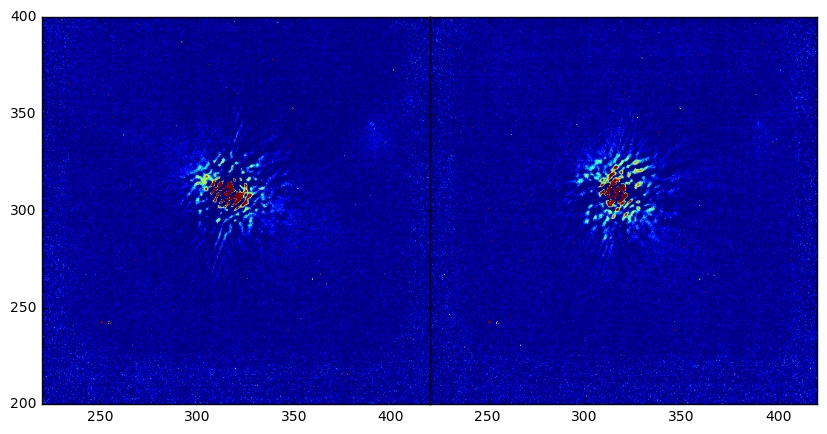

In [267]:
from matplotlib import pylab as pl
%pylab inline
import pyfits
import numpy as np
from glob import glob

fileloc='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/7QU/'
before=glob(fileloc+'*Q.fits')
before.sort()
after =glob(fileloc+'*U.fits')
after.sort()

vmin, vmax = (0, 0.05)
cmap=[cm.gray, cm.jet]
#cmap.set_bad('black',1)

extent=[220,420,200,400]
pairs=1
infile1, infile2 = before[:pairs], after[:pairs]

fig, axes = pl.subplots(nrows=pairs, ncols=2, squeeze=False, sharex=True, sharey=True, figsize=(10,5))

def showfig(axrow, x, y):
    im = axrow[0].imshow(x, cmap=cmap[1], vmin=vmin,vmax=vmax, extent=extent)#, label='{}'.format(z1[0].header['FRAMEID']))
    axrow[0].set_adjustable('box-forced')
    #image extent=[0,obj1.shape[0],0,obj1.shape[1]]
    axrow[1].imshow(y, cmap=cmap[1], vmin=vmin,vmax=vmax, extent=extent)#, label='{}'.format(z2[0].header['FRAMEID']))
    axrow[1].set_adjustable('box-forced')
    
for i,j, counter, row in zip(infile1, infile2, range(pairs), axes):
    z1=pyfits.open(i)
    z2=pyfits.open(j)
    obj1=z1[0].data
    obj2=z2[0].data
    z1.close()
    z2.close()
    showfig(row, obj1, obj2) 
fig.subplots_adjust(wspace=0, hspace=0)
#pl.tight_layout()
#fig.colorbar(im,  ax=axes.ravel().tolist(), orientation='horizontal')
pl.legend()
pl.show()

# 9 QU stacking

In [ ]:
#!/home/dl/miniconda2/envs/iraf27
'''
INPUT: rot_Q,U, and I.
OUTPUT:
Edit: 6/23
'''
from pylab import *
import pyfits
import glob
import numpy

image_array_I=[]
image_array_Q=[]
image_array_U=[]

file_list_I=glob.glob('*-*_rotI.fits')
file_list_I=list(file_list_I)
file_list_I.sort()

file_list_Q=glob.glob('*-*_rotQ.fits')
file_list_Q=list(file_list_Q)
file_list_Q.sort()

file_list_U=glob.glob('*-*_rotU.fits')
file_list_U=list(file_list_U)
file_list_U.sort()


image_array_I = array([pyfits.getdata("%s" % i) for i in file_list_I])
I_med=median(image_array_I, axis=0)

image_array_Q = array([pyfits.getdata("%s" % j) for j in file_list_Q])
Q_med=median(image_array_Q, axis=0)

image_array_U = array([pyfits.getdata("%s" % k) for k in file_list_U])
U_med=median(image_array_U, axis=0)

pyfits.writeto('I_rmed.fits',I_med)
pyfits.writeto('Q_rmed.fits',Q_med)
pyfits.writeto('U_rmed.fits',U_med)

# 10. QU Rotation

In [ ]:
#!/usr/bin/env python
"""
  To run this, I put orig sci images in a test2 folder (240-271)
  together with 184,188,..,212_QU images.
  There are total of 16 output images (8 for _rotQ and 8 for _rotU).
  Note that this is for ref star (HD241730).
  Main difference from a and b is the rotator angle value.
"""
from pylab import *
from pyraf import iraf
iraf.images()
iraf.imgeom()
import pyfits
import glob

list_Q=glob.glob('*_Q.fits')
list_Q=list(list_Q)
list_Q.sort()

first=int(list_Q[0][:-11]) #240 is the starting image (HICA*249.fits)

list_set={}
list_set[0]=first+arange(23)*4	 #23 sets of waveplates
list_set[45]=first+1+arange(23)*4 
list_set[22.5]=first+2+arange(23)*4
list_set[67.5]=first+3+arange(23)*4

### get rotation angles ###
alt=19.823806 * pi / 180.0 	#alt of Subaru in Mauna Kea

z=range(23)
set_name=map(lambda x:x*4, z)

#for the 1st four images
for i in z:		#total of 52 images in the first set
    az_list=[]
    el_list=[]
    for retarder_PA in (0,45,22.5,67.5):
        hdllist=pyfits.open("../science/HICA00141%d.fits" % list_set[retarder_PA][i])
        az_list.append(hdllist[0].header['AZIMUTH'])
        el_list.append(hdllist[0].header['ALTITUDE'])
        hdllist.close()
    az=sum(az_list)*0.25 		# Get an averaged azimuth value in rad
    az=(az-180.0)*pi/180.0     	# for the 1st for images
    el=sum(el_list)*0.25   	# Get an averaged altitude (or elevation)value in rad
    el*=pi/180.0 
    den=sin(el)*cos(az)+cos(el)*tan(alt)   # Get a parameter for field rotation
    fr=arctan2(sin(az),den)*180.0/pi 
    fr=fr+hdllist[0].header['D_IMRPAP']+180  		#rotator angle (D_IMRPAP in the fits header)= +132.0020 for its ref star (HD241730).
    name=set_name[i]+first		#start
    if fr > 360: fr-=360
    elif fr < -360: fr+=360 
    print(fr)
    q_in=str(name)+'-'+str(name+3)+'_Q.fits'
    u_in=str(name)+'-'+str(name+3)+'_U.fits'
    i_in=str(name)+'-'+str(name+3)+'_I.fits'
    q_out=str(name)+'-'+str(name+3)+'_rotQ.fits'
    u_out=str(name)+'-'+str(name+3)+'_rotU.fits'
    i_out=str(name)+'-'+str(name+3)+'_rotI.fits'
    print(q_in,q_out,u_in,u_out)
    iraf.rotate(q_in, q_out, fr, xin=320., xout=320., yin=320., yout=320.)
    iraf.rotate(u_in, u_out, fr, xin=320., xout=320., yin=320., yout=320.)
    iraf.rotate(i_in, i_out, fr, xin=320., xout=320., yin=320., yout=320.)

# 11. Polarized Image

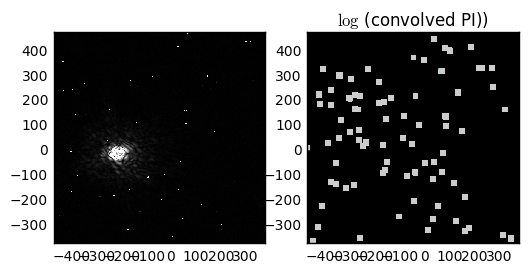

In [280]:
#!/usr/bin/env python
'''
This file is just used to change (optimize parameters)
to reveal more features associated with the extended material.
Comparison is done visually by plotting.
'''
import pyfits
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_laplace

fileloc7='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/7QU/'

a1=pyfits.open(fileloc7+'599-602_Q.fits')
Qmed=a1[0].data
a1.close()

a2=pyfits.open(fileloc7+'599-602_U.fits')
Umed=a2[0].data
a2.close()

PI=sqrt(Umed**2+Qmed**2)
PI_convolved=gaussian_filter(PI,sigma=2)

vmin1=0
vmax1=0.4#2.62
vmin2=0
vmax2=0.4#2.5

#rough estimate of object's center
xcenter_obj=355
ycenter_obj=282

pix_scale=0.00948 #HiCIAO pixel scale (arcsec/pix)
#place plot oigin to center of object
a=0-xcenter_obj
b=640-xcenter_obj
c=0-ycenter_obj
d=640-ycenter_obj
#convert pix to arcsec
extent_PI=array([a*pix_scale,b*pix_scale,c*pix_scale,d*pix_scale])
#convert arcsec to AU; distance of object is 140 pc
extent_PI*=140 #pc

xzoommin=100
xzoommax=550
yzoommin=200
yzoommax=550

fig, ax = pl.subplots(nrows=1, ncols=2)

ax[0].imshow(PI[xzoommin:xzoommax,yzoommin:yzoommax],interpolation='nearest',origin='lower',cmap=cm.gray,vmin=vmin1,vmax=vmax1,extent=extent_PI)
ax[1].imshow(log10(PI_convolved),interpolation='nearest',origin='lower',cmap=cm.spectral,vmin=vmin1,vmax=vmax1,extent=extent_PI)
#colorbar()

pl.title('$\log$ (convolved PI))')
pl.show()

###SAVE
pyfits.writeto('PI.fits', PI)

In [281]:
!ds9 PI.fits

# 12. Polarization vectors

Populating the interactive namespace from numpy and matplotlib


/home/dl/miniconda2/envs/iraf27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


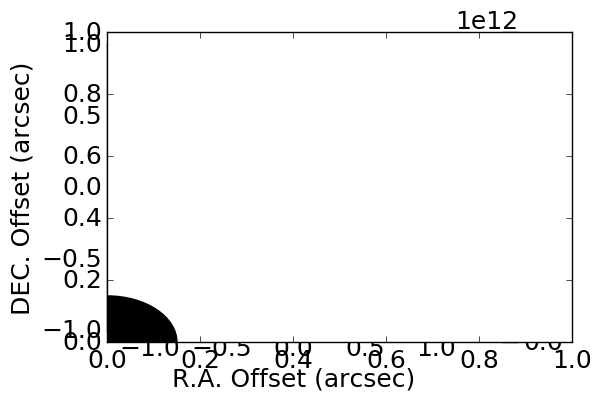

In [286]:
'''
#!/usr/bin/env python

This file generates the final PI image.
The features that can be superposed with the image include:
1) polarization vectors
	-polarization fraction calibrator
2) Ellipse (disk) fitting
	-AU pix_scale calibrator
3) geometric center of disk
4) contour plot

If viewing with polarization vector map only,
comment out the AU pix_scale calibrator and leave pol. fraction calibrator as is.
You can also remove the contour plot and disk 'x' center and ellipse fitting.

If viewing with geometrical features, comment out polarization vector
mapping and leave all else as is. Comment out AU pix_scale calibrator.
'''
from matplotlib import pylab as pl
%pylab inline
import pyfits
from scipy.ndimage.filters import gaussian_filter
from matplotlib.patches import Ellipse

import matplotlib.cm
cmap=cm.jet
#cmap.set_bad('black',1)
#change the font size for all the text in the plot updating rcParams
matplotlib.rcParams.update({'font.size': 18})

############################################################
### Constants ##############################################
############################################################

fileloc8 = '/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/8PI/'
filename = fileloc8+'PI.fits'
xcenter=350.7
ycenter=331.6

fontsize = 18
distance = 120.0
background = 9.4e-8 # PI/I_0. Measured using test.py
pix_scale  = 9.53e-3 # arcsec
scale = pix_scale*distance
scaling_factor  = 1#0.64

#Polarization fraction is greater farther from the star. Near the star, polarization vectors represent only the lower limit as polarized light reflected from the disk becomes more contaminated with unpolarized starlight
max_length=300*pix_scale       # Pol=100 %

### Classes and Modules ###
class Linear_pol_vector:
    def __init__(self,x,y,I,Q,U,ax,max_length=10,linewidth=2,color='b'):
        self.x=x
        self.y=y
        self.I=I
        self.Q=Q
        self.U=U
        self.ax=ax
        self.max_length=max_length
        self.P=sqrt(Q**2+U**2)/I
        if self.P == 0:
            self.pl,=ax.plot([self.x,self.x],[self.y,self.y],linestyle='-',color=color,
                       linewidth=2)
        else:
            self.ang=arctan2(self.U,self.Q)*0.5
            dx=self.P*cos(self.ang)*0.5*self.max_length
            dy=self.P*sin(self.ang)*0.5*self.max_length
            self.pl,=ax.plot([self.x-dx,self.x+dx],[self.y-dy,self.y+dy],
                       linestyle='-',color=color,linewidth=2)

    def change_max_length(self,max_length=10):
        if self.P != 0:
            dx=self.P*cos(self.ang)*0.5*self.max_length
            dy=self.P*sin(self.ang)*0.5*self.max_length
            self.pl.set_xdata=[self.x-dx,self.x+dx]
            self.pl.set_ydata=[self.y-dy,self.y+dy]

        def reset(self):
            self.change_max_length()
            self.pl.set_linewidth=2
            self.pl.set_color='w'

############################################################
### Begin ##################################################
############################################################

### Load the image ###
# We also subtract the background described above.
a=pyfits.open(filename)
obj_PI_a=a[0].data-background
obj_PI_a*=scaling_factor
a.close()

fileloc7='/home/dl/Downloads/research/SUAur/SUAur_data/K-band/science/test/7QU/'
#Q
d=pyfits.open(fileloc7+'599-602_Q.fits')
obj_medQa=d[0].data
d.close()
#U
e=pyfits.open(fileloc7+'599-602_U.fits')
obj_medUa=e[0].data
e.close()
#I
f=pyfits.open(fileloc7+'599-602_I.fits')
obj_medI_a=f[0].data
f.close()

#place plot origin to center of object
a=0-xcenter
b=640-xcenter
c=0-ycenter
d=640-ycenter
extent_PI=array([a,b,c,d])*pix_scale
vmin=0
vmax=amax(obj_PI_a)-0.1

### Display the results ###
fig, ax = pl.subplots(1)
#imshow(log10(obj_PI),interpolation='nearest',origin='lower',cmap=cmap,vmin=-7.5,vmax=-5,extent=extent_PI)
#colorbar(ticks=[-5.0,-5.5,-6.0,-6.5,-7.0], orientation='vertical')
pl.imshow(obj_PI_a,interpolation='nearest',origin='lower',vmin=vmin,vmax=vmax,cmap=cm.gray,extent=extent_PI)
pl.colorbar()

pl.xlabel('R.A. Offset (arcsec)', fontsize=fontsize)
pl.ylabel('DEC. Offset (arcsec)', fontsize=fontsize)
pl.xticks(fontsize=fontsize)
pl.yticks(fontsize=fontsize)
pl.axis([-1.3,1.3,-1,1])
'''
#polarization fraction calibrator: 60AU/300AU (max length) = 20%
plot([140/distance,200/distance],[-105/distance,-105/distance], color='w', linestyle='-', linewidth=3)

#arcsec calibrator, length = 70/140AU = 0.5 arcsec
ax = figure(1).add_subplot(111)
ax.plot([280/distance,350/distance],[140/distance,140/distance], color='k', linestyle='-', linewidth=3)

#label for polvec calibration
ax.text(2, 1.1, '70 AU', fontsize=fontsize, color='k')
#text for AU calibration
ax.text(1.13, -0.86, '25%', fontsize=fontsize, color='w')
'''
###cross-hair
#pl.plot([-20/distance,20/distance],[0,0], color='w', linestyle='-', linewidth=2)
#pl.plot([0,0],[-20/distance,20/distance], color='w', linestyle='-', linewidth=2)
'''
###plot contour
contour(log10(obj_PI),colors='k',levels=[-7.0,-6.75,-6.5,-6.25],linestyles='solid',extent=extent_PI)

###locate geometric center of disk in AU
plot(3/distance, -3/distance, 'wo', lw=8)

##superpose an ellipse centered at xy; geometric center offset = 2sqrt(2)AU
h,w=180/distance,140/distance
e=Ellipse(xy=(3.0/140,-3.0/140),height=h,width=w,linewidth=4,angle=15)
figure(1).add_subplot(111).add_artist(e)
e.set_ec('w')
e.set_fc('none')
e.set_ls('dashed')
'''
varray=[]
dx=dy=9
area=(2*dx+1)*(2*dy+1)

inc=20
xmin=int(xcenter-100)	#extent of the region where pol vectors will be drawn
xmax=int(xcenter+110)
ymin=int(ycenter-100)
ymax=int(ycenter+110)

x_in_as=(arange(obj_PI_a.shape[1])-xcenter)*pix_scale
y_in_as=(arange(obj_PI_a.shape[0])-ycenter)*pix_scale

for x in range(xmin,xmax,inc):
    for y in range(ymin,ymax,inc):
        r_in_as=sqrt(x_in_as[x]**2+y_in_as[y]**2)
        if r_in_as < 15*pix_scale: continue #put pol vectors outside r=15AU
        if obj_PI_a[y,x] > 0.0008: #threshold of polarization (smaller- wider)
            I=sum(obj_medI_a[y-dy:y+dy+1,x-dx:x+dx+1])/area
            Q=sum(obj_medQa[y-dy:y+dy+1,x-dx:x+dx+1])/area
            U=sum(obj_medUa[y-dy:y+dy+1,x-dx:x+dx+1])/area
            v=Linear_pol_vector(x_in_as[x],y_in_as[y],I,-Q,-U,ax,max_length=max_length,color='w')
pl.draw()

#Takami+13 used 0."3 arcsec in diameter mask
#0."3 arcsec/*0.00948arcsec/pix = 31.65 pixels
hmask,wmask= 0.3,0.3 #radius = 15 pix = 20 AU
m=Ellipse(xy=(0,0),height=hmask,width=wmask)
figure(1).add_subplot(111).add_artist(m)
m.set_color('k')
pl.show()

# Flux scaling

In [ ]:
#!/usr/bin/env python
'''
This file do flux scaling I_flux/stellar_flux of the object.
This is done by first measuring the flux of ND1 using iraf's photometry utility (phot).
The output is obj_medIaf.fits. 
'''
from pylab import *
import pyfits

ND1_flux=1711181 #measured flux using iraf's phot (in the ND1_medI_a.fits.mag.1)
stellar_flux=ND1_flux*20 #measured from iraf's phot and computed based on filter transmission (10%) and time exposure relative to object (30s- twice of ND1)

a=pyfits.open('obj_medI_a.fits')
b=a[0].data
c=b/stellar_flux
c_log=log10(c)
xcenter_obj=271
ycenter_obj=318

scale=9.53e-3*140 #HiCIAO pixel scale (arcsec/pix)
#place plot origin to center of object
a=0-xcenter_obj
b=640-xcenter_obj
c=0-ycenter_obj
d=640-ycenter_obj

#convert pix to arcsec then AU
extent_PI=array([a,b,c,d])*scale
#convert arcsec to AU; distance of object is 140 pc

imshow(c_log,interpolation='nearest',origin='lower',cmap=cm.jet,vmin=0.7,vmax=2.0,extent=extent_PI)
colorbar()

#save
#pyfits.writeto('obj_medIaf.fits',c_log)

Science dataset complete

reference star one image only

this single image is not included in 0_*.lst

STD are in qPD mode only

Flat- which one?
>copied list from Uyama-san
>use all to make master flat!

Why I didn't use dark?
>try to do this later

So far, I did crop, b, geotrans, flat.
I will skip alignment and do it later when I have I images.

The I images can then be aligned per wave plate cycle.

However, Q and U images require aligned individual channels prior to constructing the PI image.